In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Simple Trading System for Debugging

Note we inentionally build our system so BYSE is cheaper and we want to check our A/B Testing skills 
to see if we can correctly review this under different scenarios.

In [2]:
def trading_system(exchange: str) -> float:
    if exchange == "ASDAQ":
        execution_cost = 12.0
    elif exchange == "BYSE":
        execution_cost = 10.0
    else:
        raise ValueError("Exchange Not supported")
    execution_cost += np.random.normal()
    return execution_cost

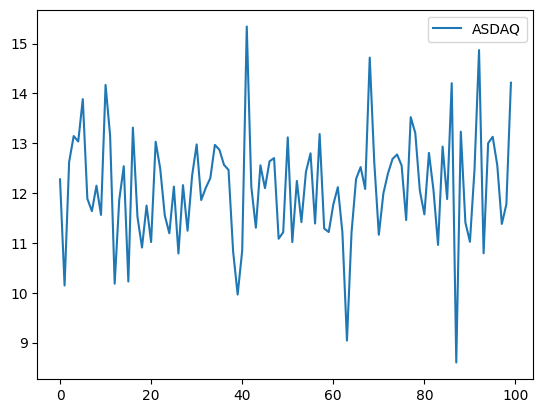

In [3]:
# Plot of the ASDAQ exchange as a function of time
np.random.seed(17)
plt.plot([trading_system("ASDAQ") for _ in range(100)])
plt.legend(["ASDAQ"])
plt.show()

In [4]:
# This observation supports our claim
np.random.seed(17)
print(trading_system("ASDAQ"))
print(trading_system("BYSE"))

print("===================")

# This observation contradicts our claim
np.random.seed(18)
print(trading_system("ASDAQ"))
print(trading_system("BYSE"))

12.27626589002132
8.145371921193496
12.079428443806204
12.190202357414222


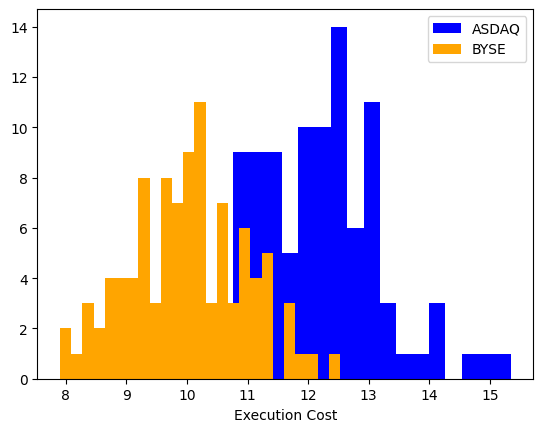

In [5]:
# Plotting the histograms of the two exchanges
np.random.seed(17)
a = np.array([trading_system("ASDAQ") for _ in range(100)])
b = np.array([trading_system("BYSE") for _ in range(100)])

plt.hist(a, 25, color ='blue')
plt.hist(b, 25, color ='orange')
plt.legend(["ASDAQ", "BYSE"])
plt.xlabel("Execution Cost")
plt.show()

## Bias and Randomization

Below is simple example how the time of day can affect our collection of samples:

Suppose we need a massive amount of measurements to detect the signal. So we take 
many measurements of BYSE in the morning, and once that process finishes, we then 
take many measuremensts of ASDAQ (now in the afternoon)

`But what if trading regardless of exchange is cheaper in the afternoon?`

In [6]:
def trading_system_tod(exchange: str, time_of_day: str) -> float:
    ''' 
    Trading system with time of day (tod) effect
    '''
    if time_of_day == "morning":
        bias = 2.5
    elif time_of_day == "afternoon":
        bias = 0.0
    else:
        raise ValueError('Not a valid time of day!')
    return trading_system(exchange) + bias

In [7]:
np.random.seed(17)
print(np.array([trading_system_tod("BYSE", "morning") for _ in range(100)]).mean())
print(np.array([trading_system_tod("ASDAQ", "afternoon") for _ in range(100)]).mean())

12.611509794247766
12.008382946497411


If we were unaware of a time-of-day (TOD) effect, we would conclude from this measurement that ASDAQ's
trading costs were lower than BYSE's and this is the opposite result of the previous section, and
it is wrong.

Also it persists: If you rerun this measurement, you'll usually get the result that ASDAQ is cheaper.

This incorrect result comes from applying the TOD bias differently and consistently to ASDAQ, 
than to BYSE.

This is known as a `confounder` bias. This leads to incorrect decisions about whether to make changes
to your system.


And of course the trick to remedy confounder bias is `randomization`!

## New Approach:

We still run our experiment in the morning and afternoon as we planned.

But every time your syßtem makes a trade, it should flip a coin.

If the coin comes up heads, send the order to ASDAQ.

If it comes up tails, send them to BYSE. You'll find that about half of your 
ASDAQ orders happen in the morning and half happen in the afternoon. 

The same will hold true for BYSE.

In [8]:
def randomized_measurement():
    asdaq_measurement = []
    byse_measurement  = []
    for tod in ["morning", "afternoon"]:
        for _ in range(100):
            if np.random.randint(2) == 0:
                asdaq_measurement.append(trading_system_tod("ASDAQ", tod))
            else:
                byse_measurement.append(trading_system_tod("BYSE", tod))
    return (np.array(asdaq_measurement).mean(),
                    np.array(byse_measurement).mean()
                    )

In [9]:
np.random.seed(17)
print(randomized_measurement())

(np.float64(13.39588870623852), np.float64(11.259639285763223))


The measurements show that ASDAQ is more expensive than BYSE, which is correct.

The pleasant thing about randomization is that we don't need to be awayre of the time-of-day bias in order to minimize its effect.

## Aggregate Measurements

By an aggregate measurement we usually mean the `standard mean`. But in general it's an estimate that comes from a collection of random measurement.

Consider the very simple example:

In [10]:
np.random.seed(17)
measurements = np.array([trading_system("ASDAQ") for _ in range(3)])
print(measurements - 12.0)
print(measurements.mean() - 12.0)

[ 0.27626589 -1.85462808  0.62390111]
-0.3181536924862769


Notice that the mean is much closer to the actual value compared to any of the individual measurements.

The mean is about 0.32 from the expectation while an individual measurement can be as far as 1.85 away.

Of course we like to think in terms of deviations (i.e. standard deviation):

In [11]:
def aggregate_measurement(exchange: str, num_individual_measurements: int) -> float:
    individual_measurements = np.array([
        trading_system(exchange)                    # take an individual measurement
        for _ in range(num_individual_measurements) # multiple times
    ])
    return individual_measurements.mean()           # then average

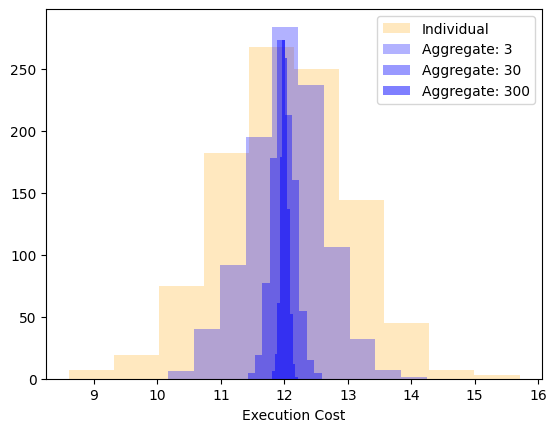

In [12]:
np.random.seed(17)
plt.hist(np.array([trading_system("ASDAQ")             for _ in range(1000)]), color = 'orange', alpha = 0.25)
plt.hist(np.array([aggregate_measurement("ASDAQ", 3)   for _ in range(1000)]), color = "blue", alpha = 0.30)
plt.hist(np.array([aggregate_measurement("ASDAQ", 30)  for _ in range(1000)]), color = "blue", alpha = 0.40)
plt.hist(np.array([aggregate_measurement("ASDAQ", 300) for _ in range(1000)]), color = "blue", alpha = 0.50)
plt.xlabel("Execution Cost")
plt.legend(["Individual", "Aggregate: 3", "Aggregate: 30", "Aggregate: 300"])
plt.show()

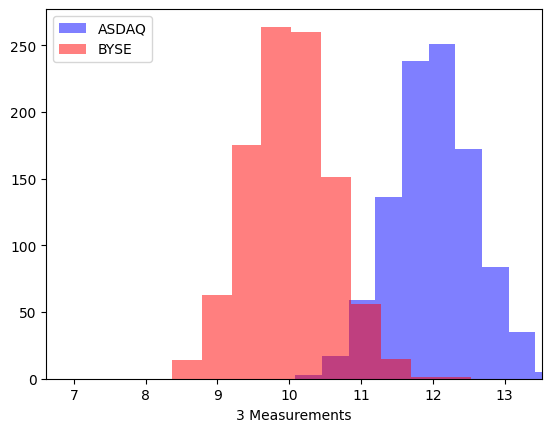

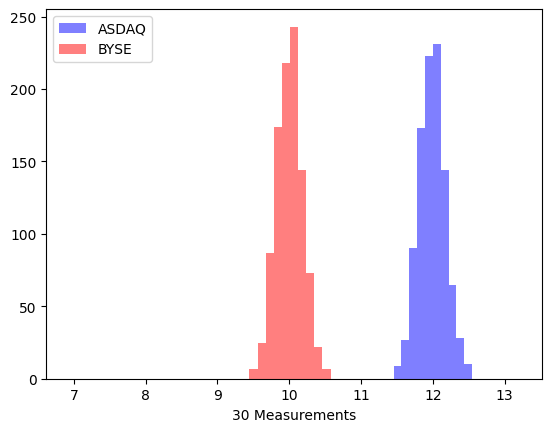

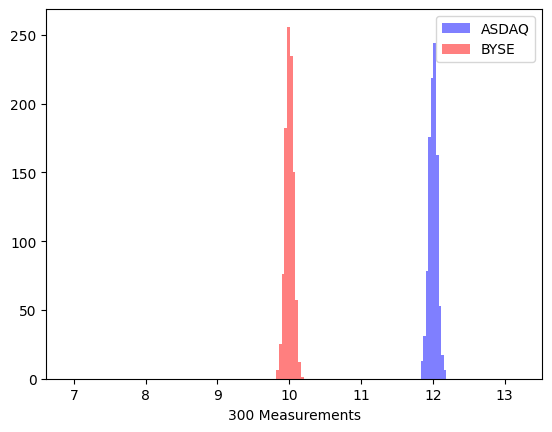

In [13]:
np.random.seed(17)
for num in [3, 30, 300]:
    plt.hist(np.array([aggregate_measurement("ASDAQ",num) for blank in range(1000)]), color = "blue", alpha = 0.50)
    plt.hist(np.array([aggregate_measurement("BYSE", num) for blank in range(1000)]), color = "red", alpha = 0.50)
    c = plt.axis()
    plt.legend(["ASDAQ", "BYSE"])
    plt.xlabel(f"{num} Measurements") 
    plt.axis([6.614, 13.52, c[2], c[3]]) # shift the plots to the right
    plt.show()